<a href="https://colab.research.google.com/github/difasapi/project/blob/main/Vegetable.23-0.956.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
# Common
import os 
import keras
import numpy as np 
import tensorflow as tf
import random

# Colab
from google.colab import files, output

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Image Load
from PIL import Image

# Callbacaks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model 
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers

In [3]:
!pip install -q kaggle

In [4]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"difafarhanihakim","key":"3d44a4b5b0da283fd36cc50bd761b3eb"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                             title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                             9KB  2022-10-06 08:55:25          14615        435  1.0              
swaptr/layoffs-2022                                             Layoffs 2022                                29KB  2022-11-16 20:46:46            968         34  1.0              
akshaydattatraykhare/data-for-admission-in-the-university       Data for Admission in the University         4KB  2022-10-27 11:05:45           3377         75  1.0              
aneesayoub/world-universities-ranking-2022   

# Download Datasets

In [6]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

vegetable-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip /content/vegetable-image-dataset.zip -d /content/

Archive:  /content/vegetable-image-dataset.zip
replace /content/Vegetable Images/test/Bean/0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
A


# Function

In [8]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set(xlabel='Epoch', ylabel='Accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set(xlabel='Epoch', ylabel='Accuracy')
    ax[1].legend()
    plt.show()

In [17]:
def show_images(GRID=[5,5], model=None, size=(20,20), Data=1):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in Data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

# Detect class name

In [18]:
root_path = '/content/Vegetable Images/train/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]

# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 15 
Class Names : ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [19]:
# Visualize 
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

# Data Load

In [20]:
input_shape = (150,150,3)
input_shape2 = (150,150)
BATCH = 32

In [21]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 370 using train_datagen generator
train_gen = train_datagen.flow_from_directory(
        root_path,  # This is the source directory for training images
        class_mode ='binary',
        target_size= input_shape2,  # All images will be resized to 200x200
        shuffle = True,
        batch_size=BATCH)

test_gen = train_datagen.flow_from_directory(
        root_path.replace('train','test'),  # This is the source directory for training images
        class_mode ='binary',
        target_size= input_shape2,  # All images will be resized to 200x200
        shuffle = True,
        batch_size=BATCH)

# Flow validation images in batches of 20 using valid_datagen generator
validation_gen = validation_datagen.flow_from_directory(
        root_path.replace('train','validation'),  # This is the source directory for training images
        class_mode ='binary',
        target_size= input_shape2,  # All images will be resized to 200x200
        shuffle = True,
        batch_size=BATCH)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


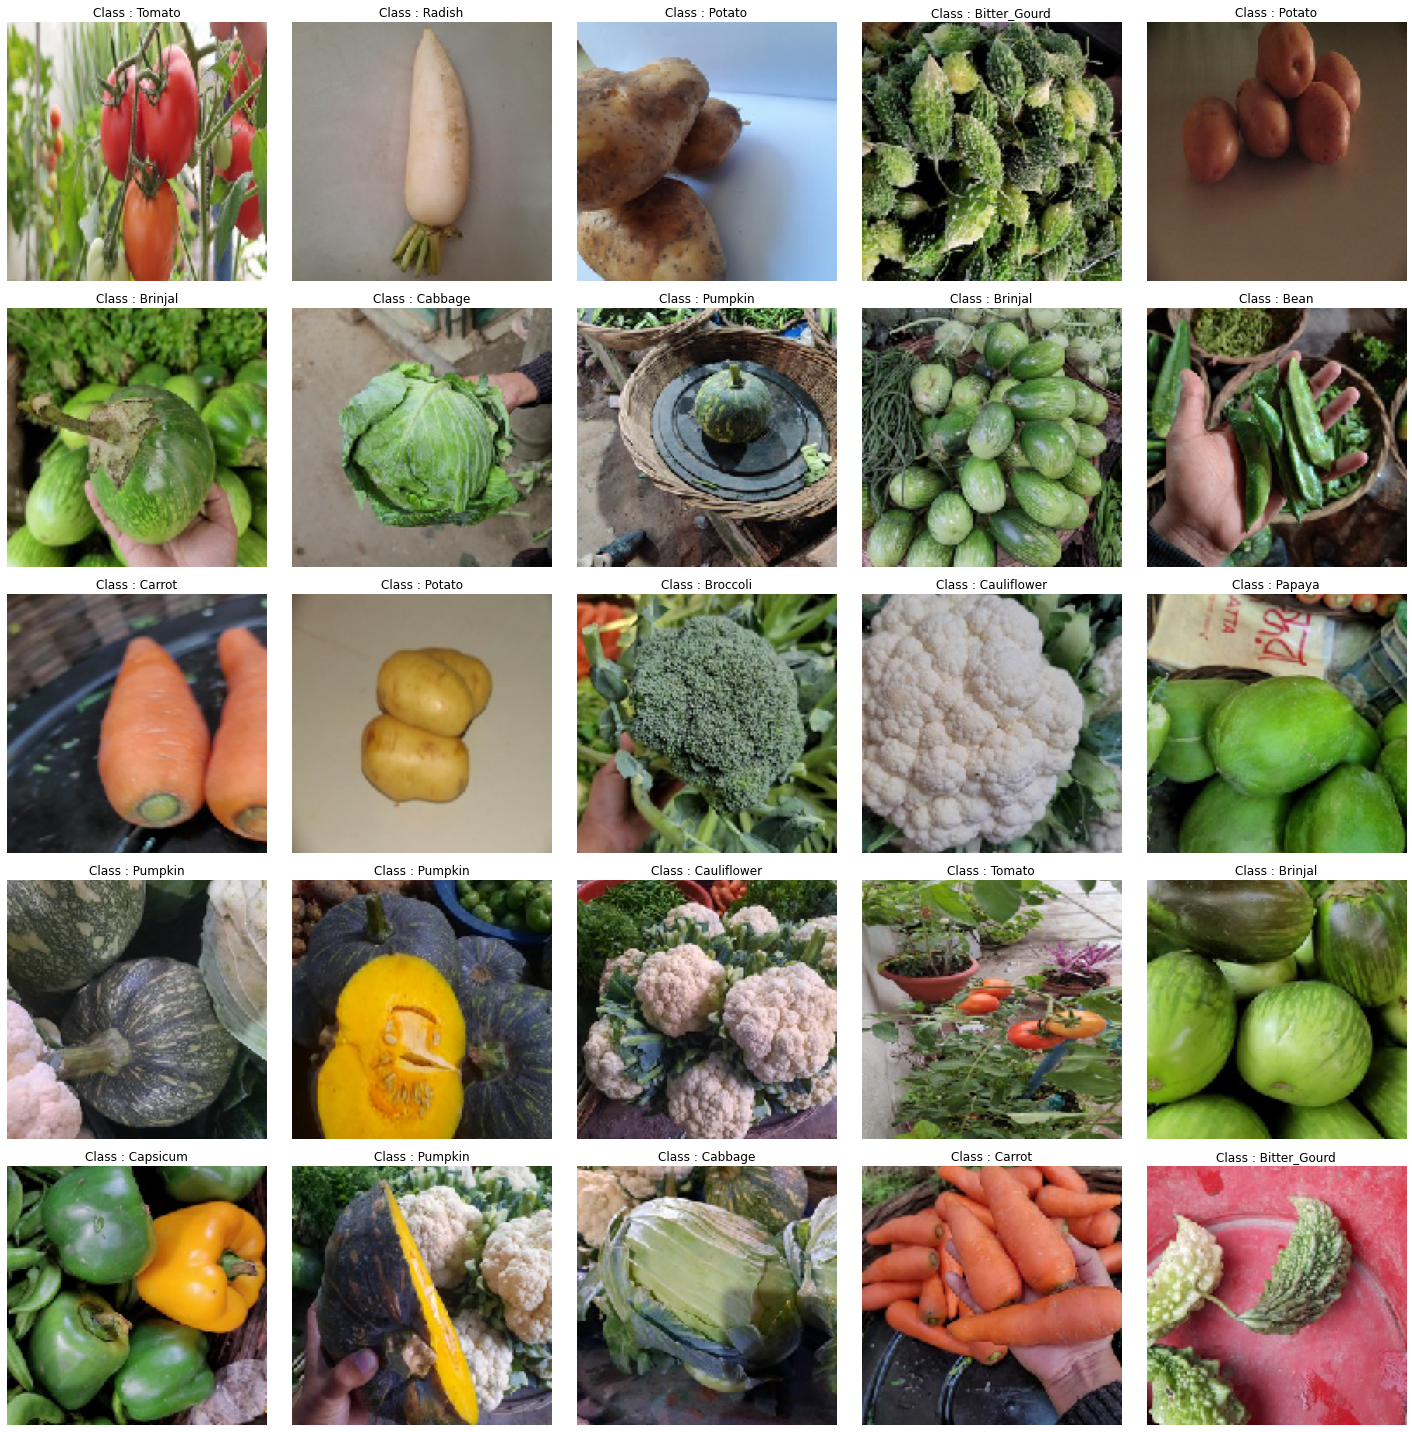

In [24]:
show_images(Data=train_gen)

# Model Vege Destroyer

In [119]:
model1 = Sequential([])

model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(n_classes, activation='softmax'))
      

In [120]:
# Architecture
model1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 17, 17, 64)     

In [121]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [122]:
name ='vegetable_destroyer'

In [123]:
cbs = [EarlyStopping(patience=5, restore_best_weights=True), 
       ModelCheckpoint('model.best.h5', save_best_only=True)]

In [124]:
step = 15000//BATCH
valid_step = 3000//BATCH

In [125]:
%%time
hist_1 = model1.fit(
      train_gen,
      validation_data = validation_gen,
      validation_steps = valid_step,
      callbacks = cbs,
      epochs = 100,
      steps_per_epoch = step,
      batch_size = BATCH)

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

Epoch 1/100
468/468 [==============================] - 40s 84ms/step - loss: 2.2624 - accuracy: 0.1790 - val_loss: 1.8328 - val_accuracy: 0.2816
Epoch 2/100
468/468 [==============================] - 35s 76ms/step - loss: 1.5678 - accuracy: 0.4026 - val_loss: 1.2884 - val_accuracy: 0.5188
Epoch 3/100
468/468 [==============================] - 35s 74ms/step - loss: 1.2121 - accuracy: 0.5447 - val_loss: 1.0876 - val_accuracy: 0.6112
Epoch 4/100
468/468 [==============================] - 35s 74ms/step - loss: 0.9361 - accuracy: 0.6658 - val_loss: 0.8554 - val_accuracy: 0.7167
Epoch 5/100
468/468 [==============================] - 37s 80ms/step - loss: 0.7111 - accuracy: 0.7573 - val_loss: 0.5766 - val_accuracy: 0.8081
Epoch 6/100
468/468 [==============================] - 34s 72ms/step - loss: 0.5810 - accuracy: 0.8143 - val_loss: 0.5643 - val_accuracy: 0.8263
Epoch 7/100
468/468 [==============================] - 34s 74ms/step - loss: 0.4336 - accuracy: 0.8625 - val_loss: 0.4711 - val_ac

In [126]:
model1.evaluate(test_gen)

94/94 [==============================] - 6s 60ms/step - loss: 0.1326 - accuracy: 0.9633


[0.13263210654258728, 0.9633333086967468]

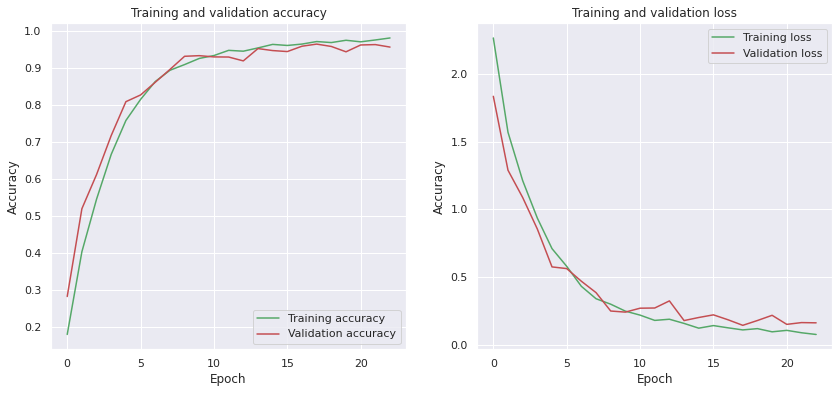

In [127]:
plot_accuracy_and_loss(hist_1)

In [128]:
hist = hist_1.history
v_acc = hist['val_accuracy'][-1]
epoch = len(hist['val_accuracy']) 
print(epoch, round(v_acc,3))
model1.save('/content/model.' + str(epoch) + '-' + str(round(v_acc,3)) + '.h5')

23 0.956


1/1 [==============================] - 0s 15ms/step


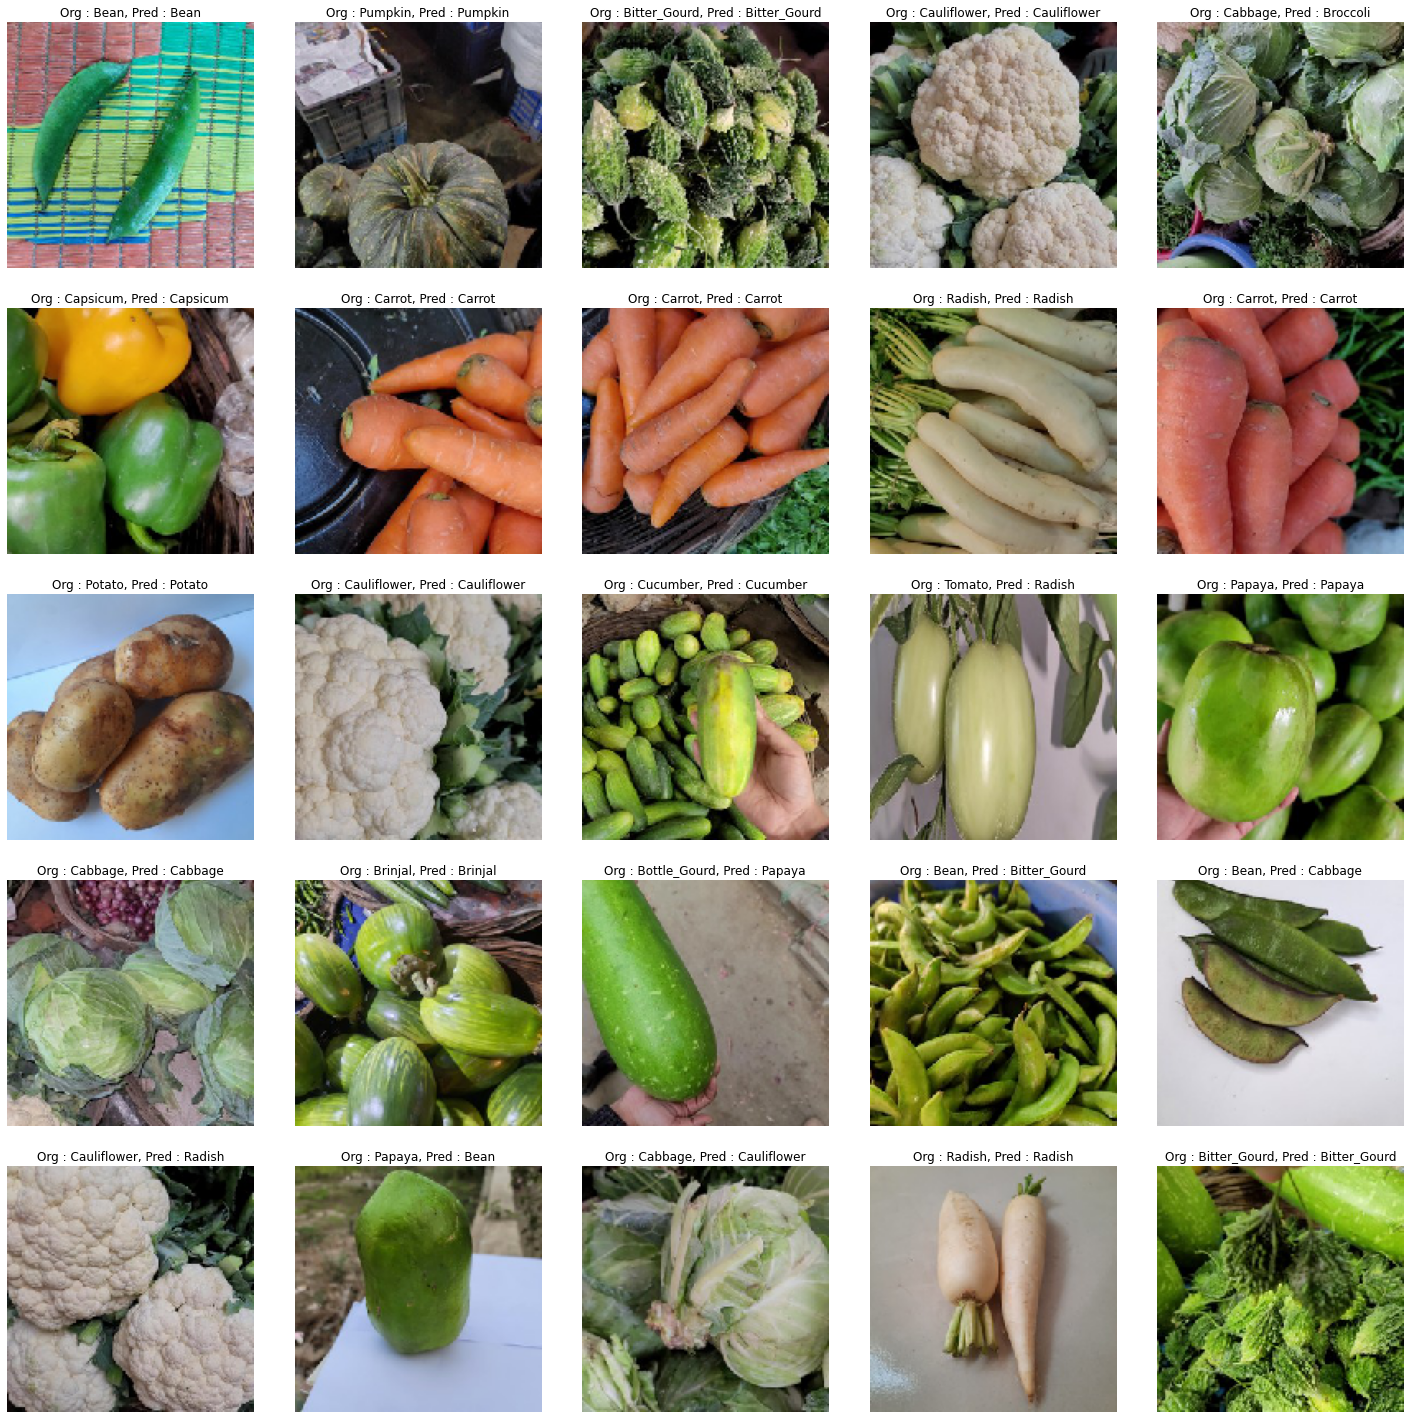

In [35]:
show_images(model=model1, Data=test_gen)

In [125]:
import shutil

In [126]:
# file_to = '/content/Vegatable CNN'
# file_format = 'zip'
# file_from = '/content/'
# shutil.make_archive(file_to, file_format, file_from)

'/content.zip'

In [ ]:
files.download('/content/Vegetable CNN destroyer.zip')

# Reference
- Download Kaggle : https://www.kaggle.com/general/74235#1376561
- Vegetable Datasets:
  * https://www.researchgate.net/publication/352846889_DCNN-Based_Vegetable_Image_Classification_Using_Transfer_Learning_A_Comparative_Study
  * https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
- Vegetable acc 99 : https://www.kaggle.com/code/utkarshsaxenadn/vegetable-classification-resnet50v2-acc-99/notebook
- Download G. Colab : 
  * https://pangpuriye.superai.me/google-colab-zip-and-unzip-file/
  * https://predictivehacks.com/?all-tips=how-to-download-files-and-folders-from-colab 
